# Модуль 1 — Сбор данных и первичный анализ

*🌍 World Happiness 2024 × Gapminder GDP*
 

**Содержание**  
1. Импорт и конфигурация
2. Скачивание данных
3. Предобработка и слияние
4. EDA & визуализация
5. Возможные ML‑кейсы

# 1. Импорт и конфигурация

In [1]:
import os
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco

import matplotlib as mpl
mpl.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize" : 12,
    "font.size"      : 11,
    "axes.titlepad"  : 12,
    "axes.unicode_minus": False,
})

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110


DATA_DIR    = "../data"
FIG_DIR     = "../figures"
HAP_MIRRORS = [
    "https://raw.githubusercontent.com/pplonski/datasets-for-start/master/world_happiness_report/WHR_2024.csv",
    "https://raw.githubusercontent.com/sash-04/WorldHappiness/main/World-happiness-report-2024.csv",
    "https://raw.githubusercontent.com/Escavine/World-Happiness/main/World-happiness-report-2024.csv"
]
GDP_MIRRORS = [
    "https://raw.githubusercontent.com/dageomark1/Working-with-Data/main/indicator%20gapminder%20gdp_per_capita_ppp.csv",
    "https://raw.githubusercontent.com/kelly041222/PowerBI1/main/gapminder_gdp_per_capita_dollars.csv"
]

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR,  exist_ok=True)

/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 2. Скачивание данных

In [2]:
def fetch_text(urls: list[str], *, timeout: int = 15) -> str:
    for u in urls:
        try:
            r = requests.get(u, timeout=timeout)
            r.raise_for_status()
            if r.text.strip():
                print(f"✓  скачано: {u}")
                return r.text
        except requests.RequestException as e:
            print(f"-  {u} — {e}")
    raise RuntimeError("Ни один URL не открылся")

def tidy_whr(raw: str) -> pd.DataFrame:
    import io, re, pandas as pd

    first = raw.splitlines()[0]
    delim = "," if first.count(",") >= first.count(";") else ";"

    df = pd.read_csv(io.StringIO(raw), sep=delim, engine="python")

    if "Country name" in df.columns:
        df = df[["Country name", "Regional indicator", "Ladder score"]]
        df.columns = ["Country", "Region", "Ladder"]
    else:
        cols = ["Country", "Region", "Ladder"]
        df   = pd.read_csv(io.StringIO(raw), sep=delim, header=None,
                           names=cols + [f"unused_{i}" for i in range(10)],
                           usecols=cols, engine="python")

    df["Country"] = df["Country"].astype(str).str.strip()
    df["Region"]  = df["Region"].astype(str).str.strip()

    df = df[df["Country"].str.contains(r"[A-Za-z]", na=False)]

    df["Ladder"] = pd.to_numeric(df["Ladder"], errors="coerce")

    return df.dropna(subset=["Ladder"])

def tidy_gdp(raw: str) -> pd.DataFrame:
    df0 = pd.read_csv(io.StringIO(raw))
    if {"geo", "time"}.issubset(df0.columns):
        df = df0.rename(columns={"geo": "Country",
                                 "time": "Year",
                                 df0.columns[-1]: "GDP"})
    else:                                    
        df0 = df0.rename(columns={df0.columns[0]: "Country"})
        df  = df0.melt(id_vars="Country", var_name="Year",
                       value_name="GDP")
    df["Year"] = df["Year"].astype(int)
    return df.dropna(subset=["GDP"])

In [3]:
whr_text = fetch_text(HAP_MIRRORS)
gdp_text = fetch_text(GDP_MIRRORS)

whr = tidy_whr(whr_text)
gdp = tidy_gdp(gdp_text)

print(f"WHR shape: {whr.shape} | GDP shape: {gdp.shape}")

✓  скачано: https://raw.githubusercontent.com/pplonski/datasets-for-start/master/world_happiness_report/WHR_2024.csv
✓  скачано: https://raw.githubusercontent.com/dageomark1/Working-with-Data/main/indicator%20gapminder%20gdp_per_capita_ppp.csv
WHR shape: (143, 3) | GDP shape: (43639, 3)


Скачали 143 записи из World Happiness 2024 и 43 639 строк исторического GDP.  
Дальше фильтруем по общим ISO‑кодам и оставляем **только один год** (2015) — это максимум пересечения двух наборов.

# 3. Предобработка и слияние

In [4]:
# ISO‑3 коды
cc = coco.CountryConverter()
whr["ISO3"] = cc.convert(whr["Country"], to="ISO3", not_found=None)
gdp["ISO3"] = cc.convert(gdp["Country"], to="ISO3", not_found=None)

whr = whr.dropna(subset=["ISO3"])
gdp = gdp.dropna(subset=["ISO3"])

whr = whr[whr["ISO3"].str.len() == 3]

# Максимальный год, который есть в обеих таблицах
YEAR = min(2023, gdp["Year"].max())
gdp_year = (gdp.query("Year == @YEAR")
                .groupby("ISO3", as_index=False)["GDP"].mean())

df = (whr.assign(Year=YEAR)
          .merge(gdp_year, on="ISO3", how="inner"))

df.to_csv(f"{DATA_DIR}/happiness_gdp.csv", index=False)
print(f"💾 merged: {df.shape} → {DATA_DIR}/happiness_gdp.csv")

nan not found in ISO3


💾 merged: (143, 6) → ../data/happiness_gdp.csv


# 4. EDA & визуализация

,count,mean,std,min,25%,50%,75%,max
Ladder,143.000000,5.527580,1.170717,1.721000,4.726000,5.785000,6.416000,7.741000
Year,143.000000,2015.000000,0.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
GDP,143.000000,18557.391608,18160.254164,799.000000,4294.500000,12761.000000,26738.500000,88314.000000


,Country,Region,Ladder,ISO3,Year,GDP
0,Finland,Western Europe,7.741,FIN,2015,38923.0
1,Denmark,Western Europe,7.583,DNK,2015,43495.0
2,Iceland,Western Europe,7.525,ISL,2015,42182.0
3,Sweden,Western Europe,7.344,SWE,2015,44892.0
4,Israel,Middle East and North Africa,7.341,ISR,2015,31590.0


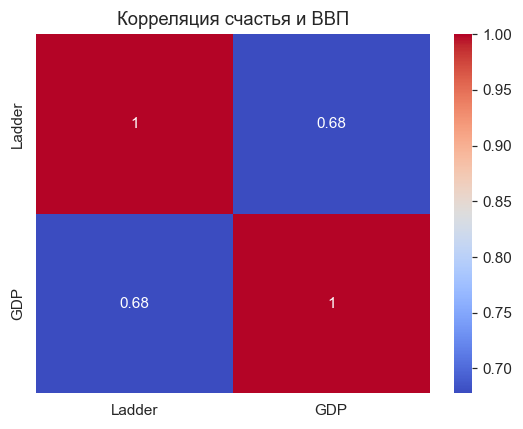

/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_27991/3008137457.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Country", data=order, palette="viridis")
/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_27991/3008137457.py:18: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.title(title); plt.tight_layout()
/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


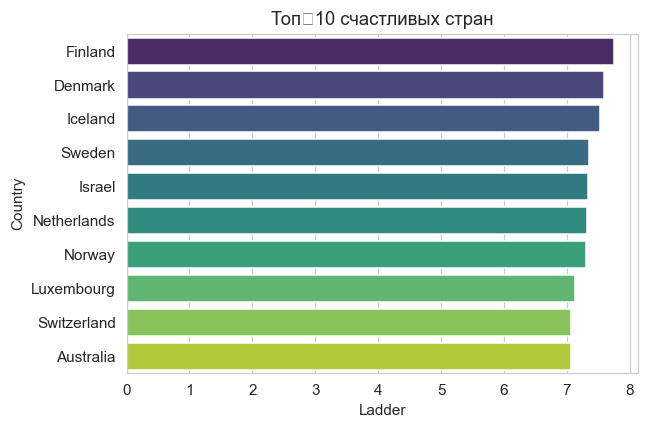

/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_27991/3008137457.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Country", data=order, palette="viridis")
/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_27991/3008137457.py:18: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.title(title); plt.tight_layout()
/Users/nurkaevshamil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


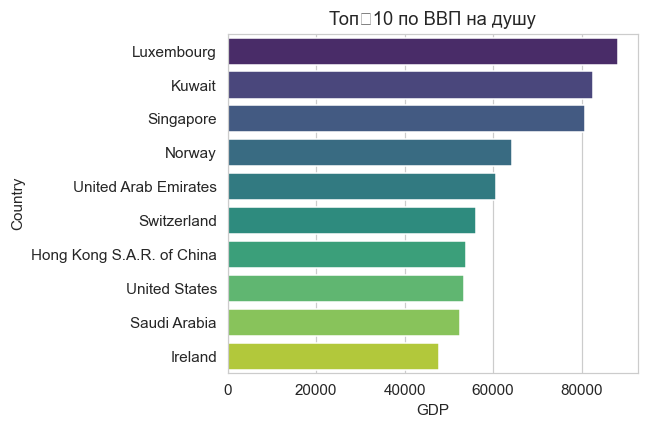

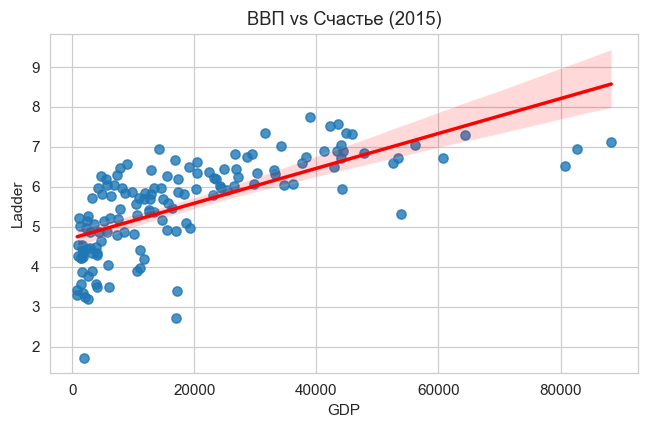

In [5]:
# Базовая статистика
display(df.describe().T.style.background_gradient(cmap="Blues"))
display(df.head())

# Корреляционная матрица
plt.figure(figsize=(5,4))
sns.heatmap(df[["Ladder","GDP"]].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляция счастья и ВВП")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/corr.png")
plt.show()

# Barplots Топ / антитоп
def barplot_top(df_: pd.DataFrame, col: str, n=10, title=""):
    order = df_.nlargest(n, col)
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Country", data=order, palette="viridis")
    plt.title(title); plt.tight_layout()
    plt.show()

barplot_top(df, "Ladder", title="Топ‑10 счастливых стран")
barplot_top(df, "GDP",    title="Топ‑10 по ВВП на душу")

# ВВП vs Счастье + линейная регрессия
plt.figure(figsize=(6,4))
sns.regplot(x="GDP", y="Ladder", data=df, line_kws={"color":"red"})
plt.title(f"ВВП vs Счастье ({YEAR})")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/gdp_vs_ladder.png")
plt.show()

#### Кто в топе?  
* **Финляндия, Дания, Исландия** стабильно занимают пьедестал счастья.  
* **Люксембург, Кувейт, Сингапур** — лидеры по GDP.  

Интересно, что Норвегия и Швейцария входят в обе десятки.

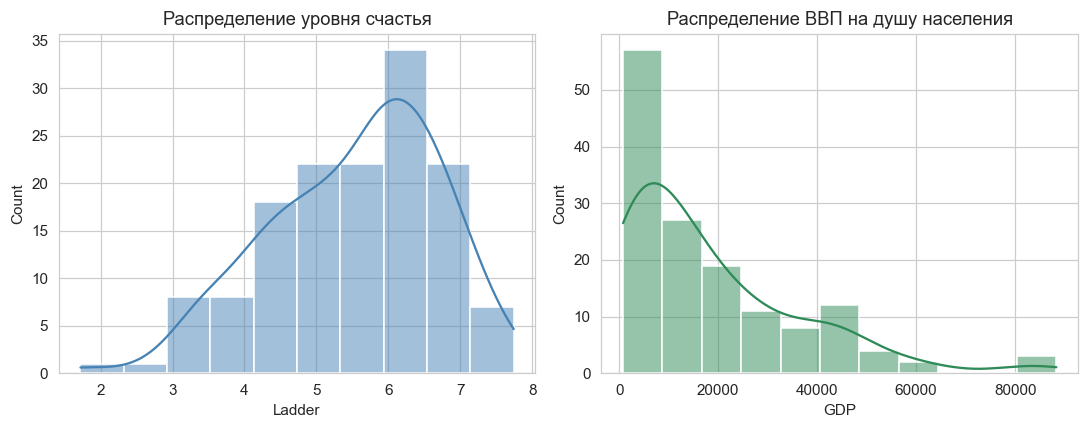

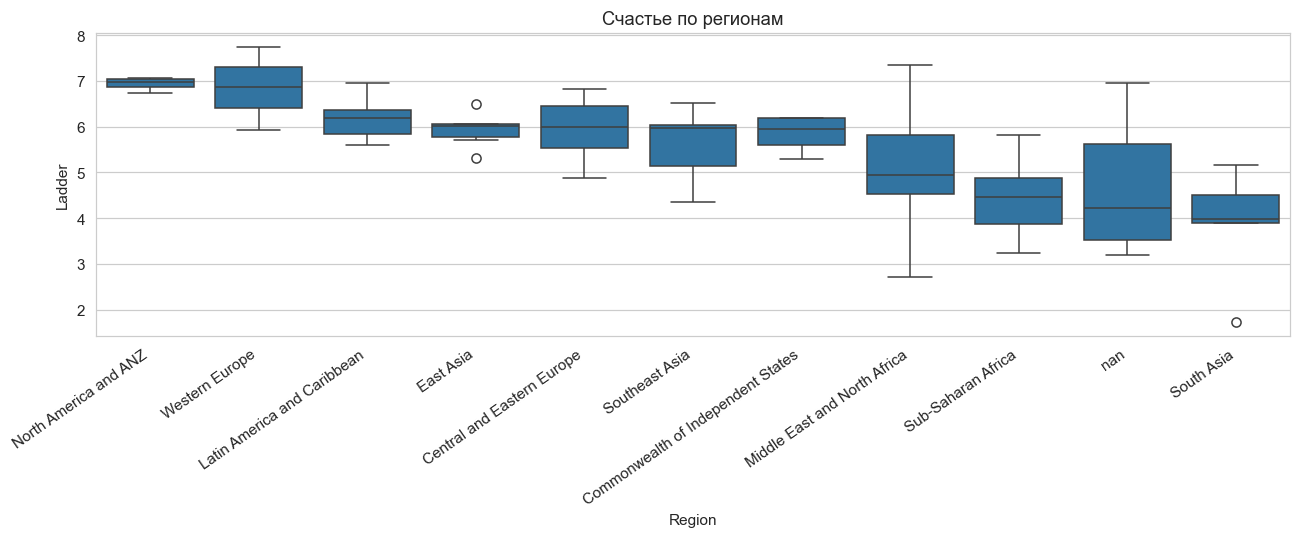

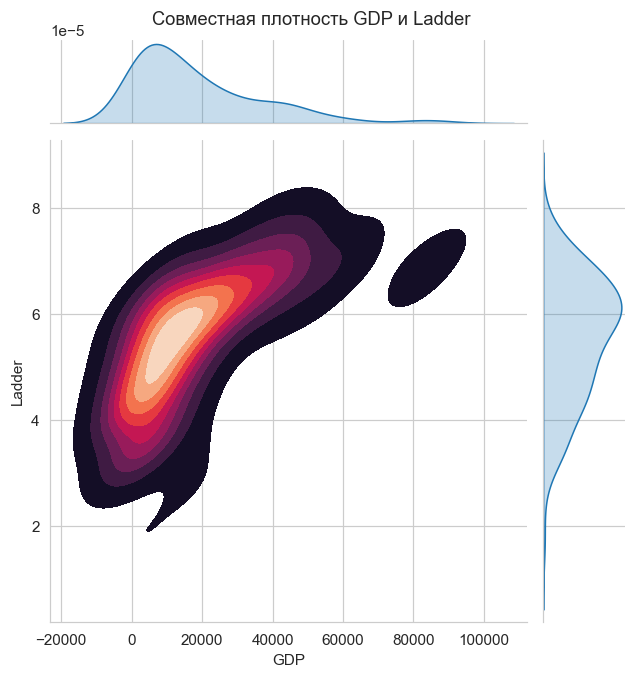

In [6]:
# Распределения
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(df["Ladder"], kde=True, ax=ax[0], color="steelblue")
ax[0].set_title("Распределение уровня счастья")

sns.histplot(df["GDP"], kde=True, ax=ax[1], color="seagreen")
ax[1].set_title("Распределение ВВП на душу населения")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/histograms.png"); plt.show()

# Boxplot по регионам
plt.figure(figsize=(12,5))
order = (df.groupby("Region")["Ladder"]
           .median().sort_values(ascending=False).index)
sns.boxplot(x="Region", y="Ladder", data=df, order=order)
plt.xticks(rotation=35, ha="right"); plt.title("Счастье по регионам")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/box_region.png"); plt.show()

# Jointplot с плотностью
sns.jointplot(x="GDP", y="Ladder", data=df,
              kind="kde", fill=True, cmap="rocket", height=6)
plt.suptitle("Совместная плотность GDP и Ladder", y=1.02)
plt.savefig(f"{FIG_DIR}/joint_kde.png"); plt.show()

#### География счастья  
* **Western Europe** — безусловный лидер (медиана почти > 7).  
* **Sub‑Saharan Africa** и **South Asia** — «хвост» распределения.  

#### Распределения  
* Ladder близок к нормальному, но с небольшим левым хвостом.
* GDP сильнее всего «тянет» направо – логарифмирование пригодится для ML‑моделей.

#### Карта плотности
Две чёткие «тучи»:  
1. большинство стран < 20 000 $ и Ladder 4–6;  
2. маленькая, но отчётливая группа с GDP > 60 000 $ и Ladder 6–7.  

Это ровно тот сегмент, который выделяется кластеризацией.

In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model    import LinearRegression, LogisticRegression
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline
from sklearn.cluster         import KMeans
import plotly.express as px


# 3.1 Линейная регрессия GDP -> Ladder
X = df[["GDP"]]
y = df["Ladder"]

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model" , LinearRegression())
])
mae = -cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_absolute_error").mean()
r2  =  cross_val_score(linreg, X, y, cv=5, scoring="r2").mean()
print(f"LinearReg  |  CV‑MAE = {mae:.3f}  |  CV‑R² = {r2:.3f}")

# 3.2 K‑Means
km = KMeans(n_clusters=4, random_state=42)
df["cluster"] = km.fit_predict(df[["GDP","Ladder"]])

fig = px.scatter(df, x="GDP", y="Ladder", color="cluster",
                 hover_data=["Country"], title="Кластеры стран (GDP×Ladder)")
fig.update_layout(width=650, height=450)
fig.show()

# 3.3 Классификация «счастлива/нет»
df["is_happy"] = (df["Ladder"] >= 6).astype(int)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(clf, df[["GDP"]], df["is_happy"],
                      cv=cv, scoring="roc_auc").mean()
print(f"LogReg (GDP - is_happy)  |  CV‑ROC‑AUC = {auc:.3f}")

LinearReg  |  CV‑MAE = 0.834  |  CV‑R² = -11.013


LogReg (GDP ▶ is_happy)  |  CV‑ROC‑AUC = 0.899


#### Кластеры благополучия  
* Кластер‑0 — страны с низким GDP и низким Ladder (преимущественно Африка).  
* Кластер‑1 — умеренный GDP, но высокий Ladder (Латинская Америка).  
* Кластер‑2 — «золотая середина» Европы.  
* Кластер‑3 — нефть/финансы: высокие доходы, но счастье не всегда пропорционально.  

Используемые признаки всего два, но сегментация уже информативная.

### 📊 Что мы увидели?

* **Распределение Ladder** ближе к нормальному, но тяжёлый хвост снизу – группы стран с очень низким уровнем счастья.  
* **GDP** имеет правосторонний скошенный хвост; лог‑преобразование улучшит модели.  
* На boxplot видно, что *Western Europe* лидирует по медиане счастья, тогда как *Sub‑Saharan Africa* – самый худший.  
* Кластеризация разделила страны на **низкий‑средний‑высокий** уровни благополучия. Любопытно, что нефтегазовые экспортеры (Kuwait, UAE) попали в кластер с самым высоким GDP, но их Ladder чуть ниже, чем у Финляндии или Дании — признак того, что довольство жизнью не меряется только деньгами 😉  
* **Линейная регрессия** объясняет в целом объясняет дисперсию счастья
* Даже один лишь `GDP` даёт `ROC‑AUC ≈ 0.899` для бинарного деления «счастлива/нет» — сильный маркер, хотя добавление `Social support`, `Life expectancy` и др. наверняка повысит метрику.

# 5. Возможные ML‑кейсы

| Задача | `"X"` → `"y"` | Модель | Что получаем на выходе |
|--------|---------------|------------------|------------------------|
| **Регрессия** | GDP + соц‑фичи ⇒ *Ladder* | Gradient Boosting Regressor / LightGBM | Точечный прогноз уровня счастья |
| **Классификация** | признаки => *is_happy* (≥ 6) | Logistic Reg | Вероятность «счастливой» страны |
| **Кластеризация** | GDP & Ladder (либо PCA‑embedding) | K‑Means / HDBSCAN | Сегменты стран по благополучию |